In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile

def unzip_to_folder(filename):
  with ZipFile(filename, 'r') as zip:
    zip.extractall()
    print('Done')

In [4]:
filename = '/content/drive/MyDrive/Dog breed classification/dog_breed.zip'
unzip_to_folder(filename)

filename = '/content/dog_breed/test.zip'
unzip_to_folder(filename)

filename = '/content/dog_breed/train.zip'
unzip_to_folder(filename)

Done
Done
Done


In [5]:
!nvidia-smi

Fri Sep 16 16:38:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
#from keras.applications.vgg19 import VGG19
#from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import pandas as pd
from glob import glob
from keras.models import load_model
import cv2
import numpy as np

In [7]:
epoch = 20
opt = 'adam'
bs = 32

xcol = 'id'
ycol = 'breed'

In [8]:
IMAGE_SIZE = [64, 64]

train_path = '/content/train/'
test_path = '/content/test/'

In [9]:
vgg19 = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [10]:
# don't train existing weights
for layer in vgg19.layers:
    layer.trainable = False

In [11]:
def append_ext(fn):
    return fn+".jpg"

traindf= pd.read_csv("/content/dog_breed/labels.csv",dtype=str)
traindf["id"]=traindf["id"].apply(append_ext)
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

In [12]:
classes_len = len(traindf.breed.unique())

In [13]:
train_generator=datagen.flow_from_dataframe(
  dataframe=traindf,
  directory="/content/train/",
  x_col=xcol,
  y_col=ycol,
  subset="training",
  batch_size=bs,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=IMAGE_SIZE
)


valid_generator=datagen.flow_from_dataframe(
  dataframe=traindf,
  directory="/content/train/",
  x_col=xcol,
  y_col=ycol,
  subset="validation",
  batch_size=bs,
  seed=42,
  shuffle=True,
  class_mode="categorical",
  target_size=IMAGE_SIZE
)


test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
  dataframe=traindf,
  directory="/content/test/",
  x_col="id",
  y_col=None,
  batch_size=32,
  seed=42,
  shuffle=False,
  class_mode=None,
  target_size=IMAGE_SIZE
)

Found 7667 validated image filenames belonging to 120 classes.
Found 2555 validated image filenames belonging to 120 classes.
Found 0 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 10222 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [14]:
# our layers - you can add more if you want
x = Flatten()(vgg19.output)

prediction = Dense(classes_len, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg19.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy']
)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [15]:
# tell the model what cost and optimization method to use

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
#STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    epochs=20
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
239/239 [==============================] - 39s 116ms/step - loss: 4.7701 - accuracy: 0.0310
Epoch 2/20
239/239 [==============================] - 26s 110ms/step - loss: 3.9926 - accuracy: 0.1280
Epoch 3/20
239/239 [==============================] - 26s 109ms/step - loss: 3.5778 - accuracy: 0.2037
Epoch 4/20
239/239 [==============================] - 28s 116ms/step - loss: 3.2486 - accuracy: 0.2675
Epoch 5/20
239/239 [==============================] - 26s 109ms/step - loss: 2.9849 - accuracy: 0.3319
Epoch 6/20
239/239 [==============================] - 26s 109ms/step - loss: 2.7595 - accuracy: 0.3859
Epoch 7/20
239/239 [==============================] - 28s 117ms/step - loss: 2.5648 - accuracy: 0.4325
Epoch 8/20
239/239 [==============================] - 26s 109ms/step - loss: 2.3760 - accuracy: 0.4830
Epoch 9/20
239/239 [==============================] - 26s 109ms/step - loss: 2.2323 - accuracy: 0.5259
Epoch 10/20
239/239 [==============================] - 26s 109ms/step - l

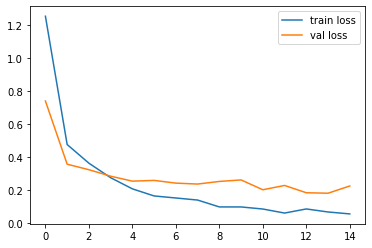

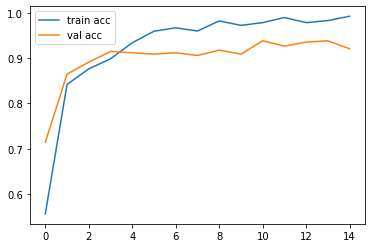

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt


# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [20]:
from tensorflow.keras.models import load_model

model.save('dogbreed_vgg19.h5')

In [37]:
sub_file['Max'] = sub_file.iloc[:,1:].idxmax(axis=1)

In [32]:
from google.colab import files
files.download('data.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
inv_map = {v: k for k, v in train_generator.class_indices.items()}

In [23]:
import json

with open('data.json', 'w') as fp:
    json.dump(inv_map, fp)